In [39]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import matplotlib.cm as cm
import matplotlib.colors as colors

* ```loadFromTSP(filename)```
* ```scatterplotOfClusters(data, centroids, labels)```
* ```plotWithinSS(avgWithinSS, **kwargs)```
* ```plotMultipleRuns(data, k, bins=20, nbrRuns=200, **kwargs)```

### Exercise 1

The list of points appears after the keyword NODE_COORD_SECTION. Your first task is to write a function that inputs the name of a TSP file and returns a numpy array, of shape (nbrPoints, 2), of its points.

att48.tsp

For example:

```python
data = loadFromTSP('data/att48.tsp')  
print('Nbr of data points: {}'.format(len(data)))
print('First five data points:\n {}'.format(data[:5]))
```

```
Nbr of data points: 48
First five data points:
 [[ 6734.  1453.]
 [ 2233.    10.]
 [ 5530.  1424.]
 [  401.   841.]
 [ 3082.  1644.]]
 ```

In [9]:
from IPython.display import Image, display

datadir = 'data/'
imagesdir = 'images/'

def display_images(images, dir=imagesdir):
    for image in images:
        display(Image(dir + image))

In [57]:
#filename = 'att48.tsp'

filename = input("Enter TSP file: ")
inputfile = open(filename, "r")
    
print("Opening File", filename, "for reading\n" )
line = inputfile.readline()

def loadFromTSP(filename):
    # """ Inputs the TSP file named by filename, and returns a (nbrPoints,2)
    # numpy array of the data points.""" 
    return np.genfromtxt(filename, usecols = (1,2), delimiter = '', skip_header = 6, skip_footer=1)


data = loadFromTSP (filename)
print('nbr of data points: {}'.format(len(data)))
print("first five:\n {}".format(data[:5]))


Enter TSP file: att48.tsp
Opening File att48.tsp for reading

nbr of data points: 48
first five:
 [[6734. 1453.]
 [2233.   10.]
 [5530. 1424.]
 [ 401.  841.]
 [3082. 1644.]]


In [40]:
import scipy.cluster.vq as vq

### Exercise 2



K-means is called like this:

centroids, labels = vq.kmeans2(data, k, minit='points')

In [19]:
#example
aa = np.array([0,0,0,1,1,0,1,1], dtype=np.float32).reshape(4,2)
ab = np.concatenate((aa, aa+10))
ab

array([[ 0.,  0.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  1.],
       [10., 10.],
       [10., 11.],
       [11., 10.],
       [11., 11.]], dtype=float32)

In [20]:
centroids, labels = vq.kmeans2(ab, 2, minit='points')
centroids, labels

(array([[10.5, 10.5],
        [ 0.5,  0.5]], dtype=float32),
 array([1, 1, 1, 1, 0, 0, 0, 0], dtype=int32))

The output tuple (centroids,labels) are interpreted together. Here it says that the first four points of the array belong to cluster 0 whose centroid is (0.5, 0.5), and the last four points belong to cluster 1 whose centroid is (10.5, 10.5). This is of course optimal for this simple problem instance but optimality is not guaranteed by k-means in general; k-means is just a heuristic.

Here are the images that result from a run of k-means on att48.tsp, for the values k=3 (i.e., 3 clusters) and k=5.

The second part of this assignment is to write a function that takes a data set (i.e., a numpy array of points) and the (centroids,labels) tuple that results from running k-means on this data set, and produces scatterplots like those above above, where each cluster gets a distinct color, and each cluster's centroid is also depicted.

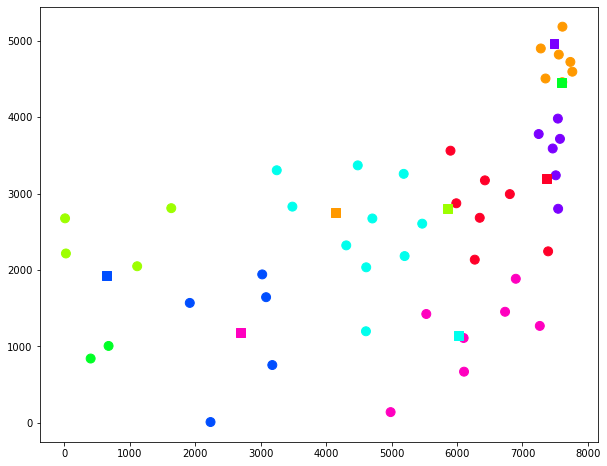

In [58]:
#filename = loadFromTSP("att48.tsp")
def scatterplotOfClusters(data, centroids, labels, cmap_name='gist_rainbow'):
    """ Takes a numpy array of data points, an array of k centroids,
    and an array of len(data) labels assigning points to centroids (clusters),
    and produces a scatterplot. 
    aHere, we have:
    centroids, labels = vq.kmeans2(data, k, minit='points')
    to produce a list of k centroids and assignments to the datapoints.
    Colors are drawn from cmap_name by interpolation."""
    plt.figure(figsize = (10, 8))
    plt.scatter(data[:, :1], data[:, 1: 2], s = 80, c = labels.reshape(len(labels), 1), cmap = cmap_name)
    plt.scatter(centroids[:, :1], centroids[:, 1: 2], s = 80, marker = 's', cmap = cmap_name, c = list(range(len(centroids))))
    
#print(data)
plt.show()
data = loadFromTSP(filename)
centroid, labels = vq.kmeans2 (data, 8, minit = 'points')
scatterplotOfClusters(data, centroids, labels)

For example:

```python
data = loadFromTSP('data/att48.tsp')  
centroids, labels = vq.kmeans2(data, 8, minit='points')
scatterplotOfClusters(data, centroids, labels)
```



The larger the value of k, the more clusters there are in the partition, and the tighter these clusters are. In effect, with more clusters, the centroids are better representatives of the dataset as a whole. There are a number of ways of capturing the quality of a partition. Here is one way. 

We define the average within-cluster sum of squared distances, to be the average of the sum of squared distances between the cluster's points and its centroid. 

Let's refer to this as WCSS(C) for cluster C. Then, we'll take the partition quality to be the average over the WCSS(C) as C ranges over the partition's clusters C.

We can use the following function to compute the quality of a partition for the dataset data, where the partition is represented by the arguments centroids and labels.


In [51]:
def avgWithinSS(data, centroids, labels):
    k = len(centroids)
    res = 0.0
    for c in range(k):
        flags = labels == c
        pointsInC = data[flags]
        def d2(p):
            delta = p - centroids[c]
            return sum(delta*delta)
        dists = np.apply_along_axis(d2, axis=1, arr=pointsInC)
        res += sum(dists) / len(pointsInC)
    return res / k


<function avgWithinSS at 0x7fc317f4b160>


When we run *avgWithinSS*, we obtain a partition quality value for *k*=len(centroids). 

Let's call this value *PQ(k)*. We can use the following function to generate an array of *PQ(k)* values as *k* ranges from 1 through *kmax*, where we choose *kmax* to be some integer no greater than the number of data points.


In [52]:
def avgWithinSSOverK(data, kmax):
    def f(k):
        return vq.kmeans2(data, k, minit='points')
    return [avgWithinSS(data, *f(k)) for k in range(1, kmax+1)]


Here we plot the partition quality values as *k* ranges from 1 through 24 for att48.tsp. Notice that the quality generally improves as *k* increases, but not always. Note k-means is run once for each value of *k*. Remember, for each value of *k*, k-means runs from a random set of *k* points. Sometimes it will converge to an excellent solution, and other times not so great a solution. On average, partition quality improves with greater *k*, but for particular runs of k-means this may not always be so.

### Exercise 3


The next part of this assignment is to write code to produce the sort of graph we have above. The graph above was produced by calling *plotWithinSS(avgWithinSSOverK(data, 24))* where *data* is the 

numpy array of data points from att48.tsp. 

In [22]:
def plotWithinSS(avgWithinSS, **kwargs):
    """ Takes an array of partition quality values, as produced by the calls
          avgWithinSSOverK(data, kmax)
        and produces a line plot of partition size by partition quality"""
    pass   # your code goes here
 

Here is the last part of this assignment. We recognize that the solutions produced by k-means are sensitive to the initial set of centers. Each time we run *vq.kmeans2(data, k, minit='points')* for the same *data* and value of *k*, we may obtain different results. This is because the *k* points used for the initial centers are chosen randomly. Here is the histogram of 2000 runs of k-means on *att48.tsp*, for *k*=8. The x-axis shows the *avgWithinSS*. Each bar corresponds to a bin indicating the number of runs whose *avgWithinSS* falls within the bin.

### Exercise 4

The histogram above was generated with this call:  *plotMultipleRuns(data, 8, 40, 2000, facecolor='green')*.  For this part of the assignment, write this function.


In [23]:
def plotMultipleRuns(data, k, bins=20, nbrRuns=200, **kwargs):
  """ Create a histogram for data by running vq.kmeans2(data, k, minit='points')
      nbrRuns times for given k. **kwargs gets passed onto the histogram function."""
    pass

IndentationError: unexpected indent (<ipython-input-23-af6d8b32b302>, line 4)

It's worth mentioning that when we run k-means with input *k*, we sometimes obtain a partition with strictly fewer than *k* clusters. In generating the partitions in plotMultipleRuns, you might want to omit such clusters. Look into the use of the *missing* parameter of the *vq.kmeans2* function